In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/7. Computer Vision Using Transformers/Decode_speech_project"
%pwd

Mounted at /content/drive
/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/7. Computer Vision Using Transformers/Decode_speech_project


'/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/7. Computer Vision Using Transformers/Decode_speech_project'

In [2]:
import random
import os
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

from torch.utils.data import DataLoader

!pip install pynwb
from pynwb import NWBHDF5IO
from custom_dataset import EEG_dataset
from seq2seq_model import EncoderDecoderAttn, EncoderDecoder, DecoderAttn, Decoder, Encoder
from utils_func import normalize_eeg_features, apply_pca, dutch_number_to_words, clean_and_convert_to_dutch, word_to_phonemes, create_phoneme_mappings, convert_words_to_phoneme_matrix
from feature_extraction import hilbert3, extractHG, stackFeatures, downsampleLabels, nameVector, remove_empty_entries

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.5/338.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 30.1 MB/s eta 0:00:00


## Feature extraction from EEG

In [4]:
# Set parameters
winL = 0.025 #0.05
frameshift = 0.01 #0.01
modelOrder = 2
stepSize = 5
path_bids = r'/content/drive/MyDrive/0. JHU MSc AI/A. MSc AI courses/7. Computer Vision Using Transformers/Decode_speech_project'
# r is to prevent \ be treated as escape in string; not necessary here
path_output = r'./features'

# Set the participant ID
participant = 'sub-01'  # Replace with the specific participant ID

# Load data
io = NWBHDF5IO(os.path.join(path_bids,  f'{participant}_task-wordProduction_ieeg.nwb'), 'r')
nwbfile = io.read()

# Extract sEEG data
eeg = nwbfile.acquisition['iEEG'].data[:]
eeg_sr = 1024

# Extract words (markers)
words = nwbfile.acquisition['Stimulus'].data[:]
words = np.array(words, dtype=str)
io.close()

# Load channel information
channels = pd.read_csv(os.path.join(path_bids, f'{participant}_task-wordProduction_channels.tsv'), delimiter='\t')
channels = np.array(channels['name'])

# Remove empty labels
eeg, words = remove_empty_entries(eeg, words)

# Extract High-gamma features
feat = extractHG(eeg, eeg_sr, windowLength=winL, frameshift=frameshift)

# Stack features
feat = stackFeatures(feat, modelOrder=modelOrder, stepSize=stepSize) # timept by chnnl

# Align words to EEG features
words = downsampleLabels(words, eeg_sr, windowLength=winL, frameshift=frameshift)
#words = words[modelOrder*stepSize:words.shape[0]-modelOrder*stepSize] # for numpy words
words = words[modelOrder*stepSize:len(words)-modelOrder*stepSize] # for list words

# Create feature names by appending the temporal shift
feature_names = nameVector(channels[:, None], modelOrder=modelOrder)

print(f"Processing completed for participant: {participant}")

/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/lib/python3.10/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Processing completed for participant: sub-01


# Process words to phonemes and tidy up feature input

In [5]:
# Apply the function get unique words
unique_words = np.unique(words)
converted_words = [clean_and_convert_to_dutch(word) for word in unique_words]
print(converted_words)

# Get min frequency of word to use as the timesteps for a word
word_frequencies = Counter(words)
num_timesteps = min(word_frequencies.values())
print(word_frequencies['helft'], num_timesteps)

['tien', 'twaalf', 'twee', 'drie', 'vijf', 'zes', 'zeven', 'acht', 'negen', 's', 'aan', 'al', 'als', 'bak', 'bakker', 'betovering', 'bevrijd', 'binnenplaats', 'boomstammen', 'braadde', 'dakker', 'dan', 'dat', 'dauwdruppel', 'direct', 'dit', 'donkere', 'door', 'een', 'en', 'er', 'gefluit', 'groen', 'haar', 'helemaal', 'helft', 'hem', 'het', 'hierop', 'hij', 'hoe', 'je', 'juist', 'kasteel', 'kin', 'komt', 'lij', 'maantje', 'maar', 'meisjes', 'met', 'mooi', 'mooie', 'naar', 'nachtegalen', 'niet', 'nog', 'of', 'om', 'onmiddellijk', 'onschuldig', 'ook', 'op', 'over', 'pak', 'redetwisten', 'schold', 'smeekte', 'spreuk', 'sprong', 'sterkste', 'stiekem', 'stilstaan', 'struik', 'te', 'teruggekregen', 'totdat', 'tussen', 'tuwiet', 'vak', 'van', 'veel', 'verdwaald', 'verstijfde', 'vloog', 'vogelkooitje', 'vogeltje', 'wak', 'wanneer', 'was', 'wegpakte', 'wel', 'werd', 'zanddak', 'ze', 'zei', 'zevenduizend', 'zich', 'zijn', 'zo']
189 187


In [6]:
# Convert EEG features into num_words x timept x chnnl
# clean y: convert arabic numbers into dutch strings and remove symbols like '
X = np.zeros([len(unique_words),num_timesteps, feat.shape[1]])
y = []
counter = 0
i = 0
while i < feat.shape[0]:
    key = words[i]
    end_pt = i + num_timesteps

    X[counter,:,:] = feat[i:end_pt,:]
    y.append(key)
    i += word_frequencies[key]

y_cleaned = [clean_and_convert_to_dutch(word) for word in y]

## Convert cleaned y to character level np array

In [7]:
seq_len = 15

word_to_phoneme = {}

for word in y_cleaned:
      # Store the phonemes directly in the defaultdict
      word_to_phoneme[word] = word_to_phonemes(word)

# Get the mappings
phoneme_to_int, int_to_phoneme = create_phoneme_mappings(word_to_phoneme)
y_char_mat = convert_words_to_phoneme_matrix(y_cleaned, seq_len, word_to_phoneme)

## PCA and normalization of feature

In [8]:
X = apply_pca(X, n_components=200)
X = normalize_eeg_features(X)

# Custom dataset, dataloader

In [9]:
# Split the data into training (90%) and testing (10%) sets
train_size = int(0.9 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_char_mat[:train_size], y_char_mat[train_size:]

# Create the dataset
train_dataset = EEG_dataset(X_train, y_train)
test_dataset = EEG_dataset(X_test, y_test)
train_dataset[0]


(tensor([[  7.0335,  -6.0352,  -5.0663,  ...,   0.5598,   1.7746,   2.3530],
         [  4.3654,  -1.2841,  -2.2809,  ...,   4.7961, -10.6605,  -4.0563],
         [  4.2030,   0.0934,  -2.6729,  ...,  -9.5816,  22.3812,  -0.4671],
         ...,
         [ 13.3248,  -8.0929,  12.2977,  ...,  -6.4049, -20.3189,   0.3555],
         [ 12.4699,  -7.8722,   2.3165,  ...,   3.1291,   8.3284,  -2.1636],
         [ 14.5477, -12.2268,  -4.6800,  ...,   1.7175,  -1.1015,   2.4065]]),
 tensor([ 7., 29., 11.,  6., 19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.]))

In [10]:
# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True)

# Example of iterating through the DataLoader
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch {batch}:")
    print("X shape:", X.shape)
    print("y shape:", y.shape, y.dtype)
    if batch == 2:  # Print only the first 3 batches
        break

print("Number of batches:", len(train_dataloader))

Batch 0:
X shape: torch.Size([5, 187, 200])
y shape: torch.Size([5, 15]) torch.float32
Batch 1:
X shape: torch.Size([5, 187, 200])
y shape: torch.Size([5, 15]) torch.float32
Batch 2:
X shape: torch.Size([5, 187, 200])
y shape: torch.Size([5, 15]) torch.float32
Number of batches: 18


# Train and evaluate seq2seq model without attention

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# X shape: (num words, eeg seq len, feature size) and y shape: (num words, output char len)
input_dim = train_dataloader.dataset[0][0].shape[1]
hidden_dim = 16*4
num_hidden_layers = 4
output_dim = 36  # Vocabulary size

# Hyperparameters
learning_rate = 0.01
num_epochs = 30

# Initialize the model
encoder = Encoder(input_dim, hidden_dim)
decoder = Decoder(hidden_dim, output_dim)
model = EncoderDecoder(encoder, decoder)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, target)
        loss = criterion(output.view(-1, output_dim), target.view(-1).long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data, target)  # Turn off teacher forcing
            loss = criterion(output.view(-1, output_dim), target.view(-1).long())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss:.4f}')


Epoch 1/30, Train Loss: 1.9685
Validation Loss: 1.2562
Epoch 2/30, Train Loss: 1.4081
Validation Loss: 1.2031
Epoch 3/30, Train Loss: 1.3437
Validation Loss: 1.1761
Epoch 4/30, Train Loss: 1.2937
Validation Loss: 1.1173
Epoch 5/30, Train Loss: 1.2794
Validation Loss: 1.0750
Epoch 6/30, Train Loss: 1.2454
Validation Loss: 1.1022
Epoch 7/30, Train Loss: 1.2223
Validation Loss: 1.0628
Epoch 8/30, Train Loss: 1.1779
Validation Loss: 1.0238
Epoch 9/30, Train Loss: 1.2545
Validation Loss: 1.0942
Epoch 10/30, Train Loss: 1.2165
Validation Loss: 1.0451
Epoch 11/30, Train Loss: 1.1570
Validation Loss: 1.0120
Epoch 12/30, Train Loss: 1.1494
Validation Loss: 1.0873
Epoch 13/30, Train Loss: 1.1707
Validation Loss: 1.0369
Epoch 14/30, Train Loss: 1.1891
Validation Loss: 1.1123
Epoch 15/30, Train Loss: 1.1264
Validation Loss: 1.0220
Epoch 16/30, Train Loss: 1.1375
Validation Loss: 1.0245
Epoch 17/30, Train Loss: 1.1527
Validation Loss: 1.0412
Epoch 18/30, Train Loss: 1.1350
Validation Loss: 1.0097
E

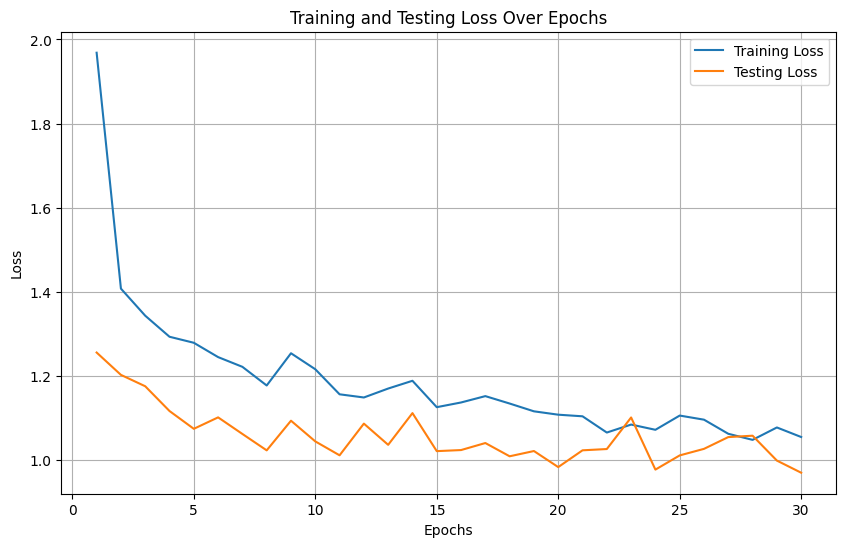

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Set model to evaluation mode
model.eval()

# Get all samples from the train_dataloader
all_samples = []
for data, target in test_dataloader:
    all_samples.extend(list(zip(data, target)))

# Randomly select 10 samples
random_samples = random.sample(all_samples, 10)

# Process the selected samples
with torch.no_grad():
    for i, (data, target) in enumerate(random_samples):
        data, target = data.unsqueeze(0).to(device), target.unsqueeze(0).to(device)
        output = model(data, target, 0)  # Turn off teacher forcing

        # Get the predicted indices
        _, predicted_indices = torch.max(output, dim=2)

        # Convert predictions and targets to phonemes
        predicted_phonemes = ''.join([int_to_phoneme[idx] for idx in predicted_indices[0].cpu().numpy() if idx in int_to_phoneme])
        target_phonemes = ''.join([int_to_phoneme[idx] for idx in target[0].cpu().numpy() if idx in int_to_phoneme])

        print(f"Sample {i + 1}:")
        print(f"Predicted: {predicted_phonemes}")
        print(f"Target:    {target_phonemes}")
        print()


Sample 1:
Predicted: zɛi             
Target:    braːddɛ         

Sample 2:
Predicted: zɛi             
Target:    zɛvɛn          

Sample 3:
Predicted: dɑr            
Target:    sprøk          

Sample 4:
Predicted: ʋɛr            
Target:    vɛrlɔst        

Sample 5:
Predicted: dɑr            
Target:    aːn             

Sample 6:
Predicted: zɛi             
Target:    zɑndbɑk        

Sample 7:
Predicted: zɛi             
Target:    hɛm            

Sample 8:
Predicted: dɑr            
Target:    doːr            

Sample 9:
Predicted: bɛ             
Target:    nʏ             

Sample 10:
Predicted: zɛi             
Target:    zʌu             



# Train and evaluate seq2seq model with attention

In [ ]:
# X shape: (num words, eeg seq len, feature size) and y shape: (num words, output char len)
input_dim = train_dataloader.dataset[0][0].shape[1]
hidden_dim = 16*4
num_hidden_layers = 4
output_dim = 36  # Vocabulary size

# Hyperparameters
learning_rate = 0.01
num_epochs = 30

# Initialize the model
encoder = Encoder(input_dim, hidden_dim)
decoder = DecoderAttn(hidden_dim, output_dim)
model = EncoderDecoderAttn(encoder, decoder)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, target)
        loss = criterion(output.view(-1, output_dim), target.view(-1).long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data, target)  # Turn off teacher forcing
            loss = criterion(output.view(-1, output_dim), target.view(-1).long())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss:.4f}')


Epoch 1/30, Train Loss: 1.7783
Validation Loss: 1.1824
Epoch 2/30, Train Loss: 1.2227
Validation Loss: 1.1149
Epoch 3/30, Train Loss: 1.1709
Validation Loss: 1.0885
Epoch 4/30, Train Loss: 1.1276
Validation Loss: 1.0607
Epoch 5/30, Train Loss: 1.0939
Validation Loss: 1.0276
Epoch 6/30, Train Loss: 1.0631
Validation Loss: 1.0173
Epoch 7/30, Train Loss: 1.0408
Validation Loss: 0.9858
Epoch 8/30, Train Loss: 1.0098
Validation Loss: 0.9888
Epoch 9/30, Train Loss: 0.9878
Validation Loss: 1.0011
Epoch 10/30, Train Loss: 0.9775
Validation Loss: 1.0168
Epoch 11/30, Train Loss: 0.9557
Validation Loss: 0.9740
Epoch 12/30, Train Loss: 0.9336
Validation Loss: 0.9988
Epoch 13/30, Train Loss: 0.9316
Validation Loss: 1.0011
Epoch 14/30, Train Loss: 0.9094
Validation Loss: 0.9832
Epoch 15/30, Train Loss: 0.8943
Validation Loss: 0.9996
Epoch 16/30, Train Loss: 0.8712
Validation Loss: 1.0025
Epoch 17/30, Train Loss: 0.8649
Validation Loss: 0.9848
Epoch 18/30, Train Loss: 0.8482
Validation Loss: 0.9957
E

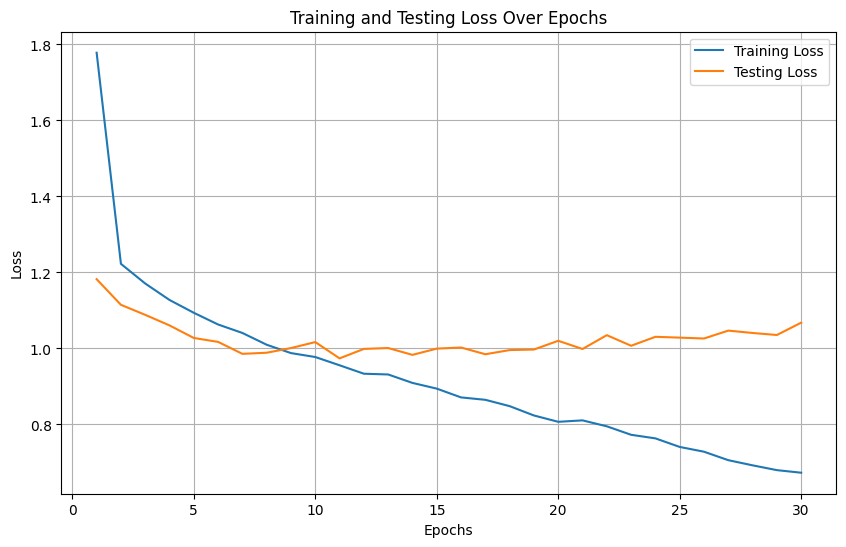

In [ ]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Set model to evaluation mode
model.eval()

# Get all samples from the train_dataloader
all_samples = []
for data, target in test_dataloader:
    all_samples.extend(list(zip(data, target)))

# Randomly select 10 samples
random_samples = random.sample(all_samples, 10)

# Process the selected samples
with torch.no_grad():
    for i, (data, target) in enumerate(random_samples):
        data, target = data.unsqueeze(0).to(device), target.unsqueeze(0).to(device)
        output = model(data, target, 0)  # Turn off teacher forcing

        # Get the predicted indices
        _, predicted_indices = torch.max(output, dim=2)

        # Convert predictions and targets to phonemes
        predicted_phonemes = ''.join([int_to_phoneme[idx] for idx in predicted_indices[0].cpu().numpy() if idx in int_to_phoneme])
        target_phonemes = ''.join([int_to_phoneme[idx] for idx in target[0].cpu().numpy() if idx in int_to_phoneme])

        print(f"Sample {i + 1}:")
        print(f"Predicted: {predicted_phonemes}")
        print(f"Target:    {target_phonemes}")
        print()


Sample 1:
Predicted: bɑm sɑ         
Target:    braːddɛ         

Sample 2:
Predicted: hɛi             
Target:    hɛm            

Sample 3:
Predicted: zɑr n          
Target:    zɛvɛn          

Sample 4:
Predicted: dɑiɔ           
Target:    doːr            

Sample 5:
Predicted: zɑr  ɑ         
Target:    zɑndbɑk        

Sample 6:
Predicted: tti nt         
Target:    sprøk          

Sample 7:
Predicted: bɑm            
Target:    aːn             

Sample 8:
Predicted: tɛr taː ɛ       
Target:    vɛrlɔst        

Sample 9:
Predicted: zɑn            
Target:    zʌu             

Sample 10:
Predicted: mɛn            
Target:    nʏ             

